<a href="https://colab.research.google.com/gist/jonghank/8541a559cd582f32edd7a1fbd71c4f83/robust_kalman_filter_with_huber_penalty_functions_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robust Kalman filter with Huber penalty functions

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\argmin}{{\text{argmin}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\E}{\mathbf{E}}
\newcommand{\var}{\mathbf{var}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\B}{\mathbf{B}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$

__<div style="text-align: right"> ASE7030: Convex Optimization, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_


<br>

Recall the Kalman filtering problem. A discrete-time linear dynamical system consists of a sequence of state vectors $x_t \in \R^n$, indexed by time $t\in \{0,\dots,N-1\}$ and dynamics equations

$$
\begin{aligned}
  x_{t+1} &= Ax_t + B w_t \\
  y_{t} &= Cx_t + v_t   
\end{aligned}
$$

where $w_t\in\R^n$ is an input to the dynamical system (say, a drive force on the vehicle), $y_t\in\R^r$ is a state measurement, $v_t\in\R^r$ is noise, $A$ is the drift matrix, and $C$ is the observation matrix.

Given $A$, $B$, $C$, and $y_t$ for $t=0,\dots,N−1$, the goal is to estimate $x_t$ for $t=0,\dots,N−1$.

<br>

A Kalman filter estimates $x_t$ by solving the optimization problem 

$$
\begin{aligned}
  \underset{x,w,v}{\minimize} \quad & \sum_{t=0}^{N-1} \|w_t\|^2 + \tau\|v_t\|^2   \\
  \text{subject to} \quad & x_{t+1} = Ax_t + Bw_t\\
  & y_t = Cx_t + v_t, \qquad t=0,\dots,N-1 \
\end{aligned}
$$

with some tuning parameters $\tau$.

<br>

The following generates a sample trajectory of a point mass on a plane.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n = 1000 # number of timesteps
T = 50 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,n+1)
delt = T/n
gamma = 0.05 # damping, 0 is no damping

A = np.zeros((4,4))
B = np.zeros((4,2))
C = np.zeros((2,4))

A[0,0] = 1
A[1,1] = 1
A[0,2] = (1-gamma*delt/2)*delt
A[1,3] = (1-gamma*delt/2)*delt
A[2,2] = 1 - gamma*delt
A[3,3] = 1 - gamma*delt

B[0,0] = delt**2/2
B[1,1] = delt**2/2
B[2,0] = delt
B[3,1] = delt

C[0,0] = 1
C[1,1] = 1

<br>

The following simulates the system to $T=50$, with $\Delta t=0.05$, with
$$
{\bf E}(w_t w_t^T) = \bmat{ 1 & \\ & 1 }
$$
and 
$$
{\bf E}(v_t v_t^T) = \bmat{ 4 & \\ & 4 }
$$


In [2]:
from scipy.linalg import sqrtm 

np.random.seed(7030)

x = np.zeros((4,n+1))
x[:,0] = [0,0,0,0]
y = np.zeros((2,n))

Q = np.diag([1,1])
R = np.diag([4,4])
Qh = sqrtm(Q)
Rh = sqrtm(R)

w = Qh@np.random.randn(2,n)
v = Rh@np.random.randn(2,n)

for t in range(n):
    x[:,t+1] = A.dot(x[:,t]) + B.dot(w[:,t])
    y[:,t]   = C.dot(x[:,t]) + v[:,t]
    
x_true = x.copy()
w_true = w.copy()
v_true = v.copy()

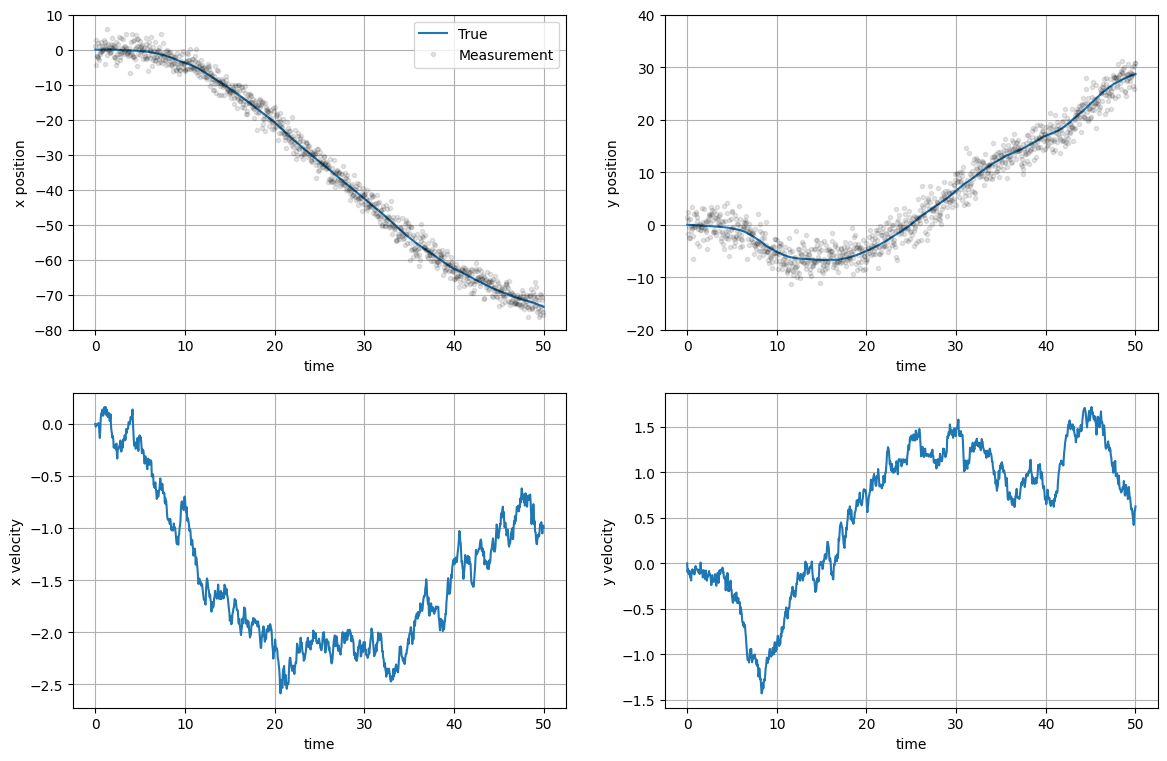

In [3]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,x[0,:], label='True')
plt.plot(ts[:-1],y[0,:], 'k.', alpha=0.1, label='Measurement')
plt.xlabel('time')
plt.ylabel('x position')
plt.legend()
plt.ylim([-80,10])
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x[1,:])
plt.plot(ts[:-1],y[1,:], 'k.', alpha=0.1)
plt.xlabel('time')
plt.ylabel('y position')
plt.ylim([-20,40])
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x[2,:])
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x[3,:])
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

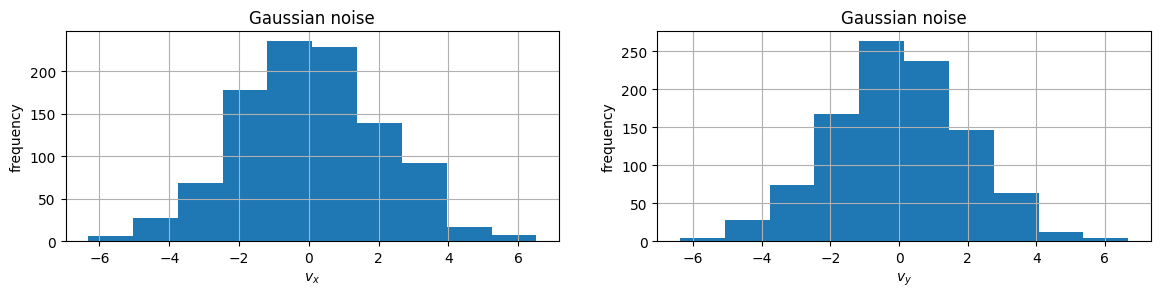

In [4]:
plt.figure(figsize=(14,6), dpi=100)
plt.subplot(2,2,1)
plt.hist(v_true[0,:], bins=10)
plt.xlabel(r'$v_x$')
plt.ylabel('frequency')
plt.title('Gaussian noise')
plt.grid()
plt.subplot(2,2,2)
plt.hist(v_true[1,:], bins=10)
plt.xlabel(r'$v_y$')
plt.ylabel('frequency')
plt.title('Gaussian noise')
plt.grid()
plt.show()

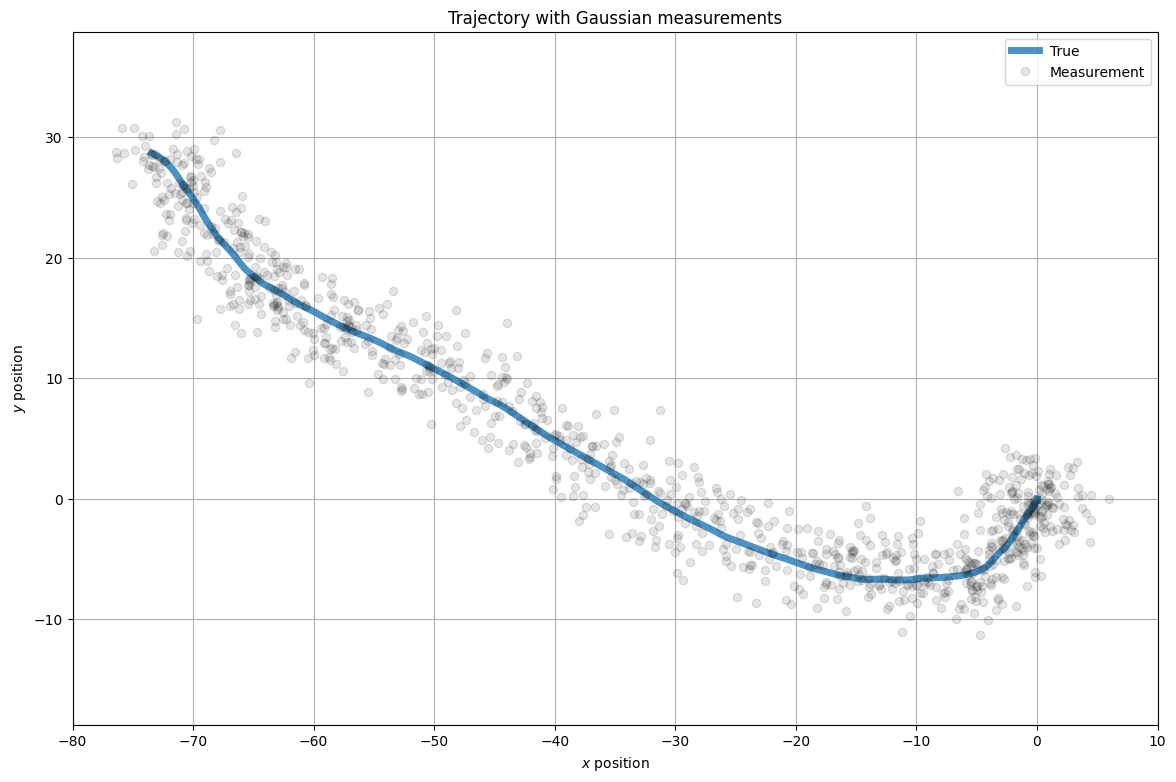

In [5]:
plt.figure(figsize=(14,9), dpi=100)
plt.plot(x[0,:],x[1,:],'-',alpha=0.8, linewidth=5, label='True')
plt.plot(y[0,:],y[1,:],'ko',alpha=0.1, label='Measurement')
plt.title('Trajectory with Gaussian measurements')
plt.legend()
plt.grid()
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.axis('equal')
plt.xlim([-80,10])
plt.ylim([-20,40])
plt.show()

<br>

By using `cvxpy`, the Kalman filter solution can be found by

In [6]:
import cvxpy as cp

x = cp.Variable(shape=(4, n+1))
w = cp.Variable(shape=(2, n))
v = cp.Variable(shape=(2, n))

tau = 0.16
    
obj = cp.sum_squares(w) + tau*cp.sum_squares(v)
obj = cp.Minimize(obj)

constr = []
for t in range(n):
    constr += [ x[:,t+1] == A@x[:,t] + B@w[:,t] ,
                y[:,t]   == C@x[:,t] + v[:,t]   ]

cp.Problem(obj, constr).solve(verbose=True)

x_cvx = np.array(x.value)
w_cvx = np.array(w.value)
v_cvx = np.array(v.value)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) May 23 03:34:17 AM: Your problem has 8004 variables, 2000 constraints, and 0 parameters.
(CVXPY) May 23 03:34:17 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 23 03:34:17 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 23 03:34:17 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 23 03:34:17 AM: Compiling problem (target solver=OSQP).
(CVXPY) May 23 03:34:17 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStu

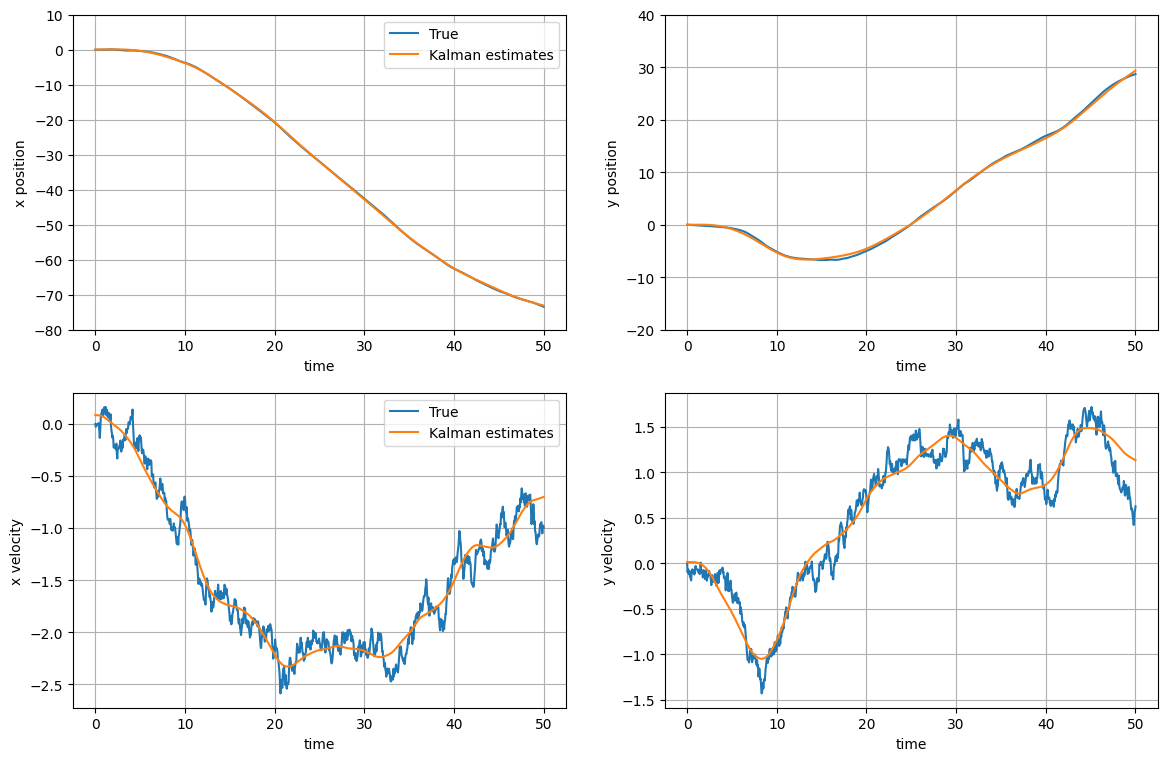

In [7]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,x_true[0,:], label='True')
plt.plot(ts,x_cvx[0,:], label='Kalman estimates')
plt.xlabel('time')
plt.ylabel('x position')
plt.legend()
plt.ylim([-80,10])
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_true[1,:])
plt.plot(ts,x_cvx[1,:])
plt.xlabel('time')
plt.ylabel('y position')
plt.ylim([-20,40])
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_true[2,:], label='True')
plt.plot(ts,x_cvx[2,:], label='Kalman estimates')
plt.xlabel('time')
plt.ylabel('x velocity')
plt.legend()
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_true[3,:])
plt.plot(ts,x_cvx[3,:])
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

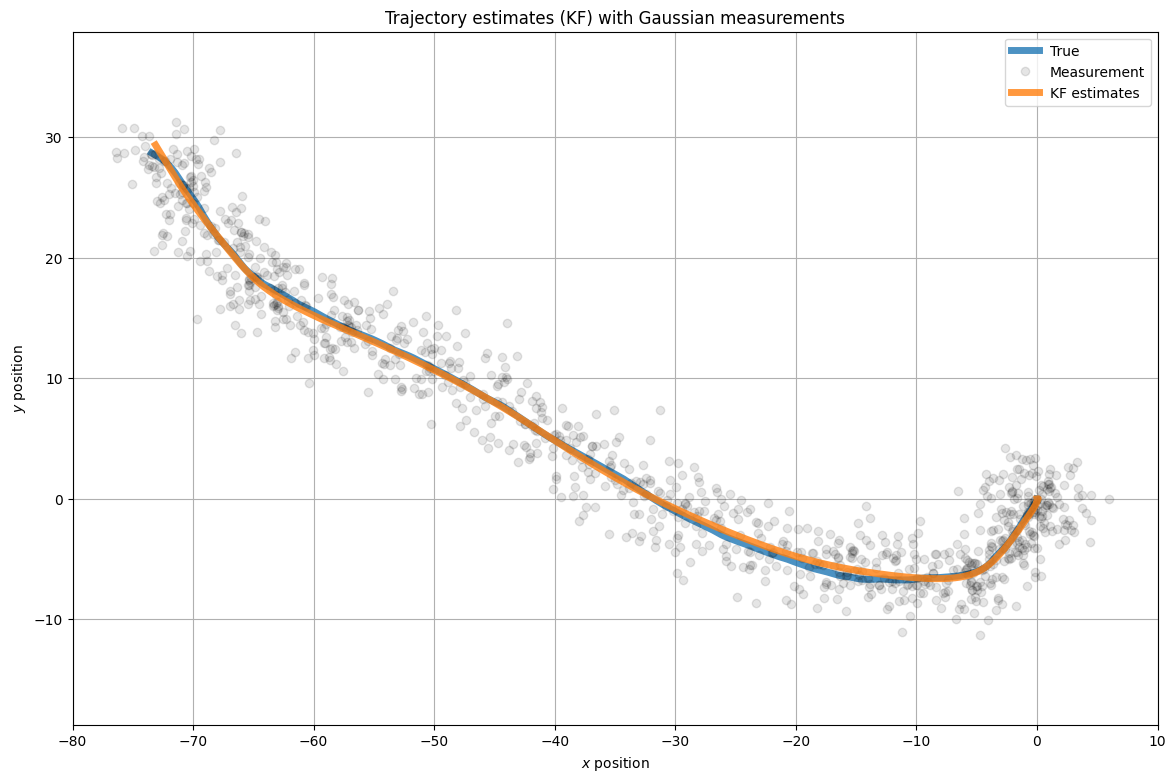

In [8]:
plt.figure(figsize=(14,9), dpi=100)
plt.plot(x_true[0,:],x_true[1,:],'-',alpha=0.8, linewidth=5, label='True')
plt.plot(y[0,:],y[1,:],'ko',alpha=0.1, label='Measurement')
plt.plot(x_cvx[0,:],x_cvx[1,:],'-',alpha=0.8, linewidth=5, label='KF estimates')
plt.title('Trajectory estimates (KF) with Gaussian measurements')
plt.grid()
plt.legend()
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.axis('equal')
plt.xlim([-80,10])
plt.ylim([-20,40])
plt.show()

<br>

<br>

We present a nasty situation where the position measurement system (such as GPS) was jammed, where the measurement noise, $v$, was amplified by a factor of 30 with probability of 25%, i.e., approximately a quarter of the measurements were severely jammed.

In [9]:
np.random.seed(7030)

x = np.zeros((4,n+1))
x[:,0] = [0,0,0,0]
y = np.zeros((2,n))

Q = np.diag([1,1])
R = np.diag([4,4])
Qh = sqrtm(Q)
Rh = sqrtm(R)

w = Qh@np.random.randn(2,n)
v = Rh@np.random.randn(2,n)

for t in range(n):
  if np.random.rand() < 0.25:
    v[:,t] *= 30

for t in range(n):
    x[:,t+1] = A.dot(x[:,t]) + B.dot(w[:,t])
    y[:,t]   = C.dot(x[:,t]) + v[:,t]
    
x_true = x.copy()
w_true = w.copy()
v_true = v.copy()

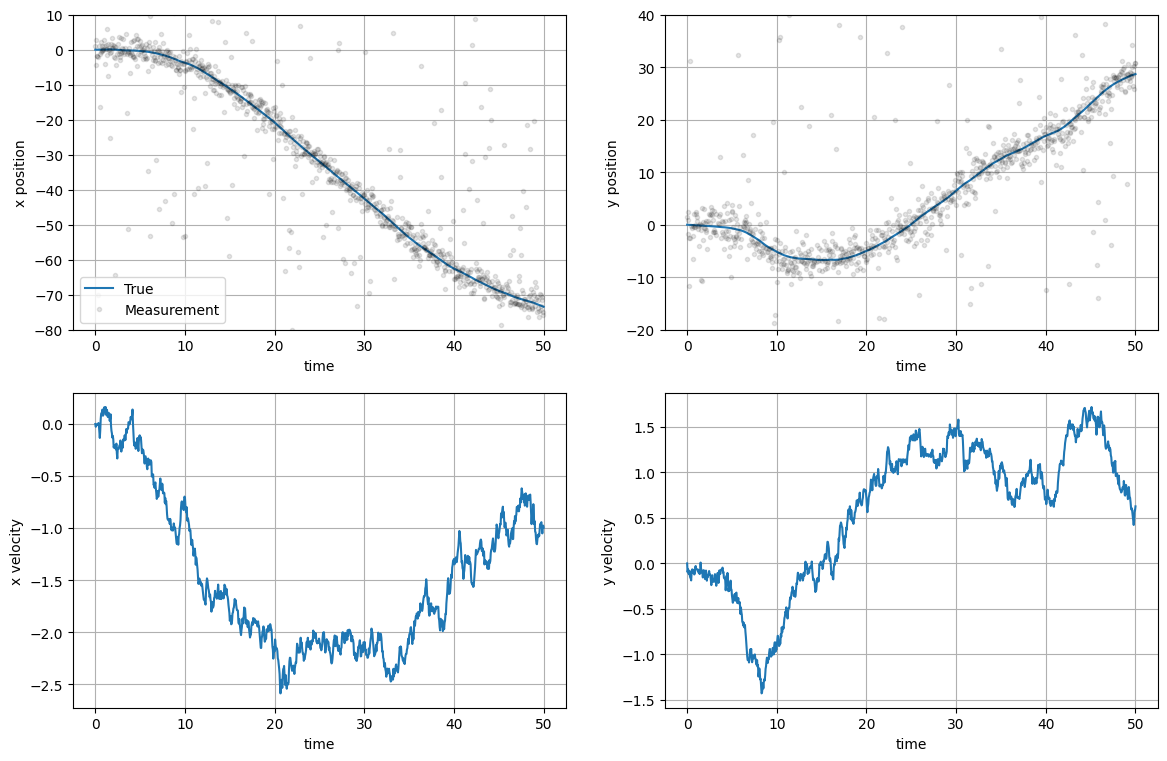

In [10]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,x_true[0,:], label='True')
plt.plot(ts[:-1],y[0,:], 'k.', alpha=0.1, label='Measurement')
plt.xlabel('time')
plt.ylabel('x position')
plt.legend()
plt.ylim([-80,10])
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_true[1,:])
plt.plot(ts[:-1],y[1,:], 'k.', alpha=0.1)
plt.xlabel('time')
plt.ylabel('y position')
plt.ylim([-20,40])
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_true[2,:])
plt.xlabel('time')
plt.ylabel('x velocity')
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_true[3,:])
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

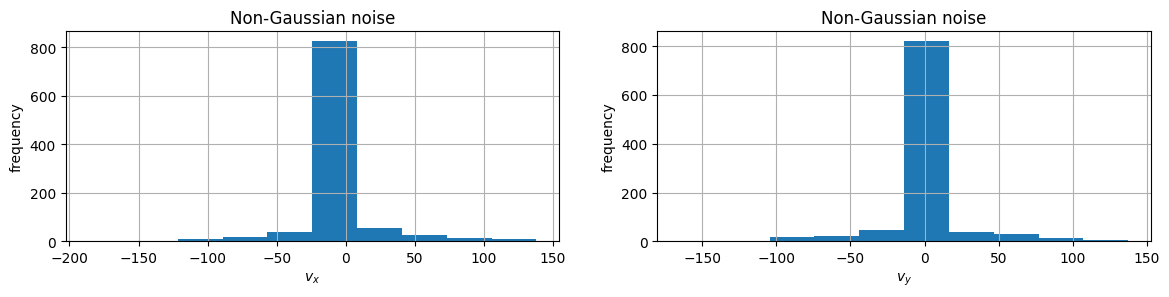

In [11]:
plt.figure(figsize=(14,6), dpi=100)
plt.subplot(2,2,1)
plt.hist(v_true[0,:], bins=10)
plt.xlabel(r'$v_x$')
plt.ylabel('frequency')
plt.title('Non-Gaussian noise')
plt.grid()
plt.subplot(2,2,2)
plt.hist(v_true[1,:], bins=10)
plt.xlabel(r'$v_y$')
plt.ylabel('frequency')
plt.title('Non-Gaussian noise')
plt.grid()
plt.show()

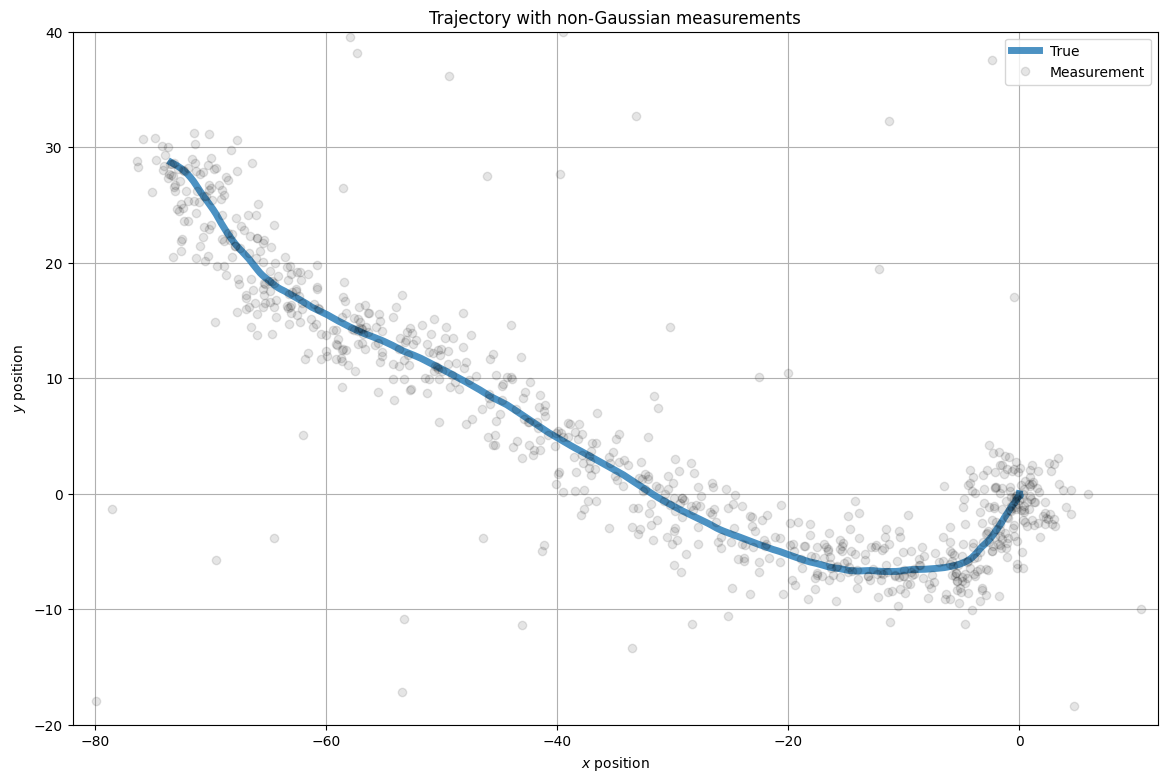

In [12]:
plt.figure(figsize=(14,9), dpi=100)
plt.plot(x[0,:],x[1,:],'-',alpha=0.8, linewidth=5, label='True')
plt.plot(y[0,:],y[1,:],'ko',alpha=0.1, label='Measurement')
plt.title('Trajectory with non-Gaussian measurements')
plt.grid()
plt.legend()
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.axis('equal')
plt.xlim([-80,10])
plt.ylim([-20,40])
plt.show()

<br>

The Kalman filter is optimal for Gaussian noises, but the estimates can be severely deteriorated when the follow non-Gaussian distribution. Running the same Kalman filter gives you

In [13]:
import cvxpy as cp

x = cp.Variable(shape=(4, n+1))
w = cp.Variable(shape=(2, n))
v = cp.Variable(shape=(2, n))

tau = 0.16
    
obj = cp.sum_squares(w) + tau*cp.sum_squares(v)
obj = cp.Minimize(obj)

constr = []
for t in range(n):
    constr += [ x[:,t+1] == A@x[:,t] + B@w[:,t] ,
                y[:,t]   == C@x[:,t] + v[:,t]   ]

cp.Problem(obj, constr).solve(verbose=True)

x_kf = np.array(x.value)
w_kf = np.array(w.value)
v_kf = np.array(v.value)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) May 23 03:34:23 AM: Your problem has 8004 variables, 2000 constraints, and 0 parameters.
(CVXPY) May 23 03:34:23 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 23 03:34:23 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 23 03:34:23 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 23 03:34:23 AM: Compiling problem (target solver=OSQP).
(CVXPY) May 23 03:34:23 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStu

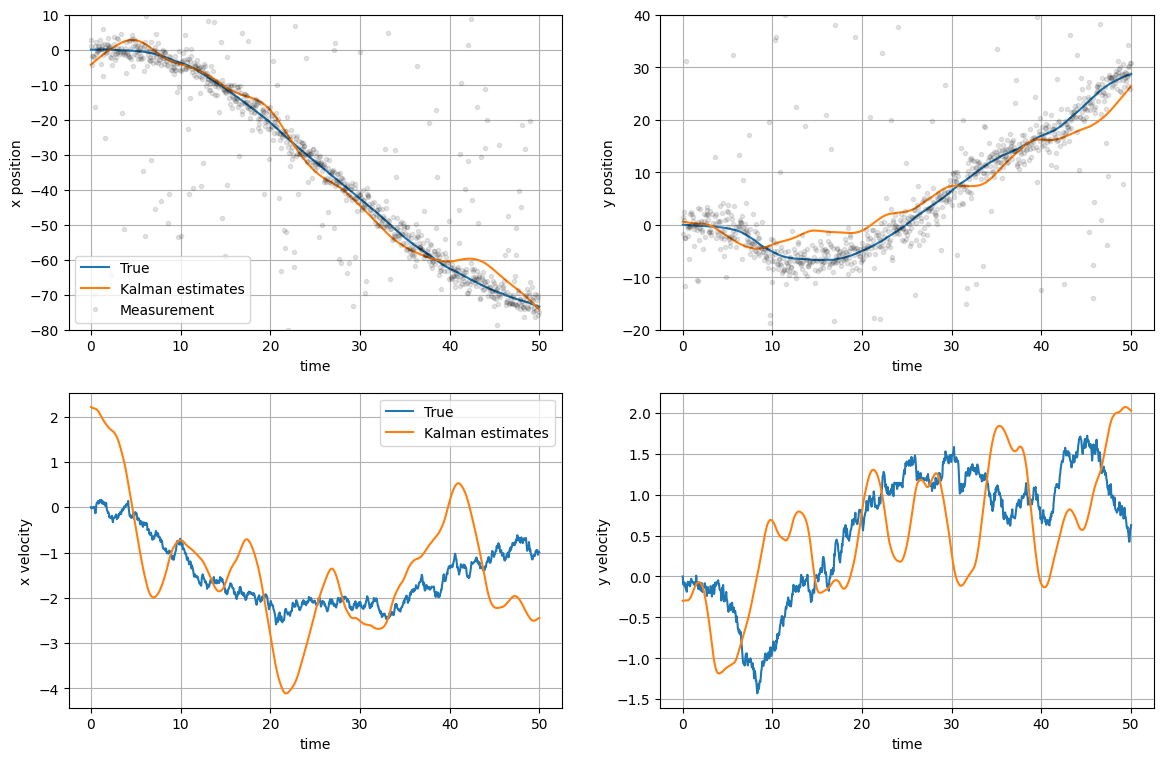

In [14]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,x_true[0,:], label='True')
plt.plot(ts,x_kf[0,:], label='Kalman estimates')
plt.plot(ts[:-1],y[0,:], 'k.', alpha=0.1, label='Measurement')
plt.xlabel('time')
plt.ylabel('x position')
plt.legend()
plt.ylim([-80,10])
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_true[1,:])
plt.plot(ts,x_kf[1,:])
plt.plot(ts[:-1],y[1,:], 'k.', alpha=0.1)
plt.xlabel('time')
plt.ylabel('y position')
plt.ylim([-20,40])
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_true[2,:], label='True')
plt.plot(ts,x_kf[2,:], label='Kalman estimates')
plt.xlabel('time')
plt.ylabel('x velocity')
plt.legend()
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_true[3,:])
plt.plot(ts,x_kf[3,:])
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

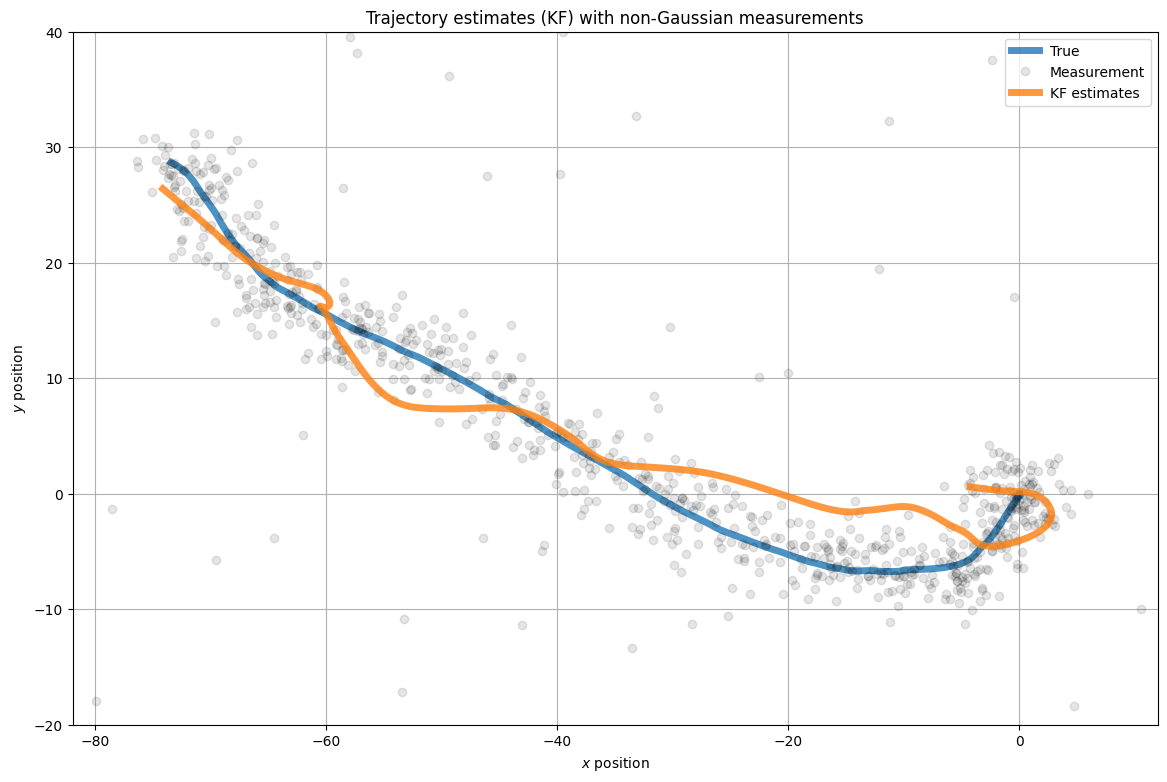

In [15]:
plt.figure(figsize=(14,9), dpi=100)
plt.plot(x_true[0,:],x_true[1,:],'-',alpha=0.8, linewidth=5, label='True')
plt.plot(y[0,:],y[1,:],'ko',alpha=0.1, label='Measurement')
plt.plot(x_kf[0,:],x_kf[1,:],'-',alpha=0.8, linewidth=5, label='KF estimates')
plt.title('Trajectory estimates (KF) with non-Gaussian measurements')
plt.grid()
plt.legend()
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.axis('equal')
plt.xlim([-80,10])
plt.ylim([-20,40])
plt.show()

<br>

<br>


Now we modify the problem again with a different regularizer.

$$
\begin{aligned}
  \underset{x,w,v}{\minimize} \quad & \sum_{t=0}^{N-1} \|w_t\|^2 + \tau h_\rho (\|v_t\|)   \\
  \text{subject to} \quad & x_{t+1} = Ax_t + Bw_t\\
  & y_t = Cx_t + v_t, \qquad t=0,\dots,N-1 \
\end{aligned}
$$

with some tuning parameters $\tau$ and $\rho$.

The regularizer, $h_\rho(\cdot)$, also known as the Huber function, is defined by

$$
h_\rho(x) = \begin{cases}
x^2 &\quad \text{if } |x| \le \rho \\
\rho\left(2|x|-\rho\right) &\quad \text{if }|x| \gt \rho
\end{cases}
$$
 
which (with $\rho=1$) looks like below.



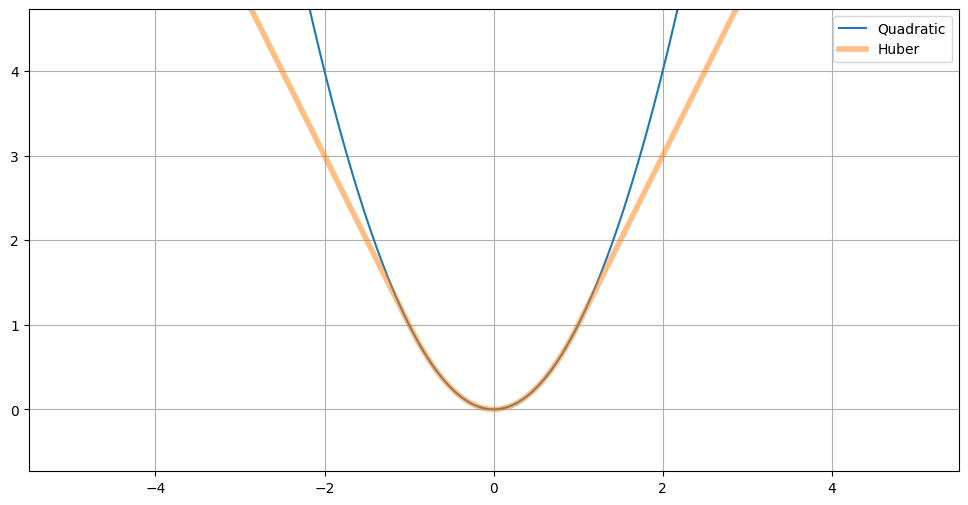

In [16]:
from scipy.special import huber
x_test = np.linspace(-5,5,500)
plt.figure(figsize=(12,6), dpi=100)
plt.plot(x_test,x_test**2, label='Quadratic')
plt.plot(x_test,2*huber(1,x_test), linewidth=4, alpha=0.5, label='Huber')
plt.axis('equal')
plt.legend()
plt.ylim(0,4)
plt.grid()
plt.show()

In [17]:
import cvxpy as cp

x = cp.Variable(shape=(4, n+1)) 
w = cp.Variable(shape=(2, n))
v = cp.Variable(shape=(2, n))

tau = 0.16
rho = 2.0
    
obj = cp.sum_squares(w)
obj += sum(tau*cp.huber(cp.norm(v[:,t]),rho) for t in range(n))
obj = cp.Minimize(obj)

constr = []
for t in range(n):
    constr += [ x[:,t+1] == A@x[:,t] + B@w[:,t] ,
                y[:,t]   == C@x[:,t] + v[:,t]   ]

cp.Problem(obj, constr).solve(verbose=True)

x_rkf = np.array(x.value)
w_rkf = np.array(w.value)
v_rkf = np.array(v.value)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) May 23 03:34:28 AM: Your problem has 8004 variables, 2000 constraints, and 0 parameters.
(CVXPY) May 23 03:34:29 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 23 03:34:29 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 23 03:34:29 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 23 03:34:29 AM: Compiling problem (target solver=ECOS).
(CVXPY) May 23 03:34:29 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

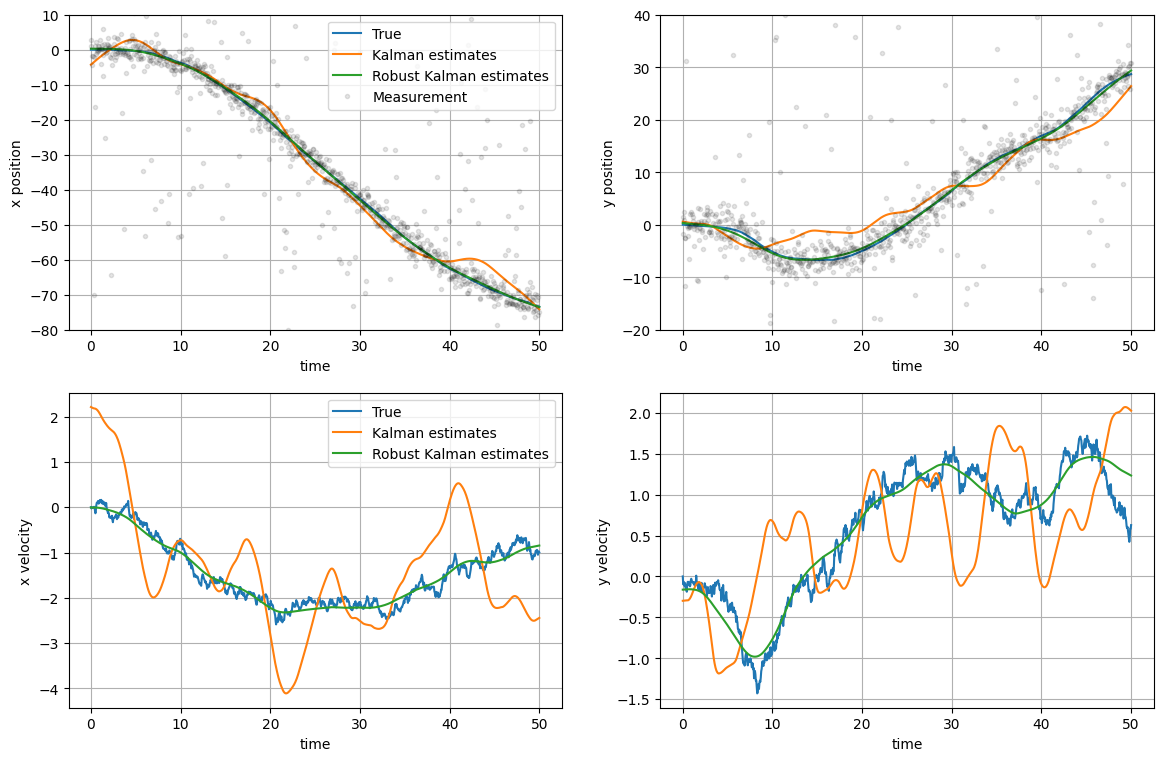

In [18]:
plt.figure(figsize=(14,9), dpi=100)
plt.subplot(2,2,1)
plt.plot(ts,x_true[0,:], label='True')
plt.plot(ts,x_kf[0,:], label='Kalman estimates')
plt.plot(ts,x_rkf[0,:], label='Robust Kalman estimates')
plt.plot(ts[:-1],y[0,:], 'k.', alpha=0.1, label='Measurement')
plt.xlabel('time')
plt.ylabel('x position')
plt.legend()
plt.ylim([-80,10])
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_true[1,:])
plt.plot(ts,x_kf[1,:])
plt.plot(ts,x_rkf[1,:])
plt.plot(ts[:-1],y[1,:], 'k.', alpha=0.1)
plt.xlabel('time')
plt.ylabel('y position')
plt.ylim([-20,40])
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_true[2,:], label='True') 
plt.plot(ts,x_kf[2,:], label='Kalman estimates')
plt.plot(ts,x_rkf[2,:], label='Robust Kalman estimates')
plt.xlabel('time')
plt.ylabel('x velocity')
plt.legend()
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_true[3,:])
plt.plot(ts,x_kf[3,:])
plt.plot(ts,x_rkf[3,:])
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()

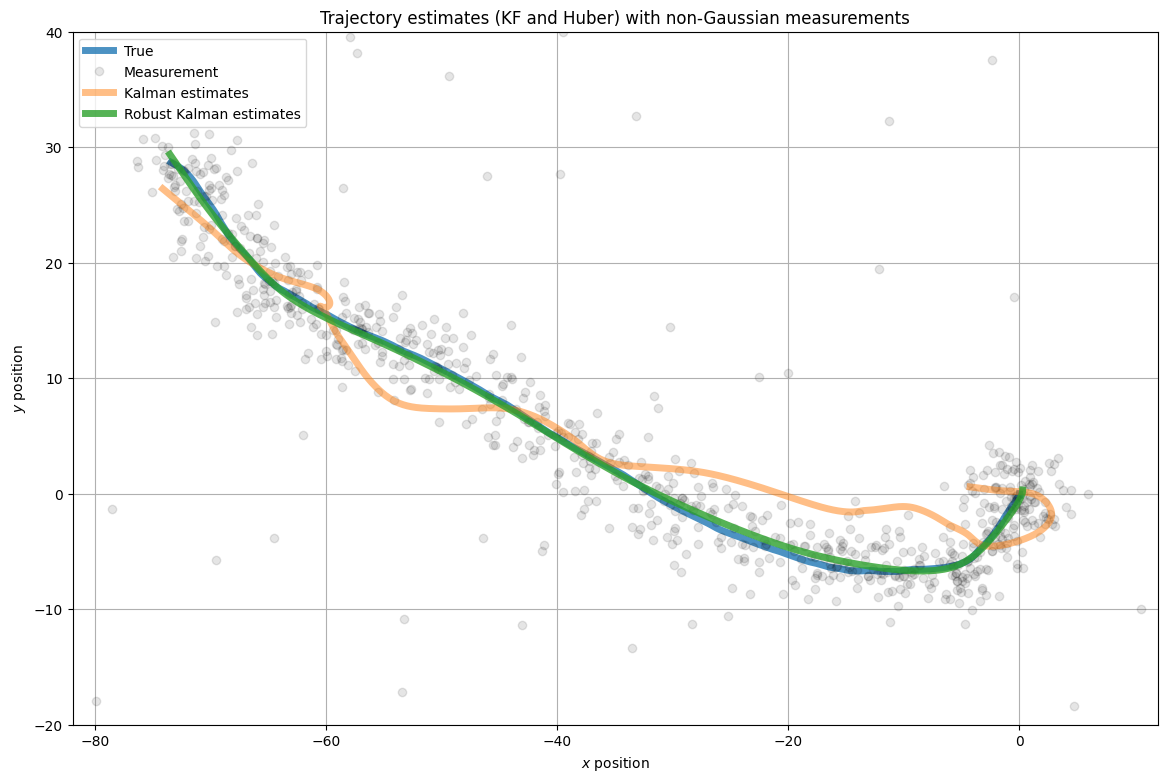

In [19]:
plt.figure(figsize=(14,9), dpi=100)
plt.plot(x_true[0,:],x_true[1,:],'-',alpha=0.8, linewidth=5, label='True')
plt.plot(y[0,:],y[1,:],'ko',alpha=0.1, label='Measurement')
plt.plot(x_kf[0,:],x_kf[1,:],'-',alpha=0.5, linewidth=5, label='Kalman estimates')
plt.plot(x_rkf[0,:],x_rkf[1,:],'-',alpha=0.8, linewidth=5, label='Robust Kalman estimates')
plt.title('Trajectory estimates (KF and Huber) with non-Gaussian measurements')
plt.grid()
plt.legend()
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.axis('equal')
plt.xlim([-80,10])
plt.ylim([-20,40])
plt.show()